# Twin-Delayed DDPG

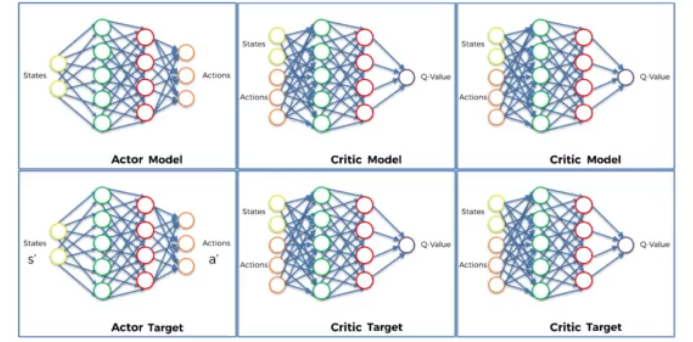

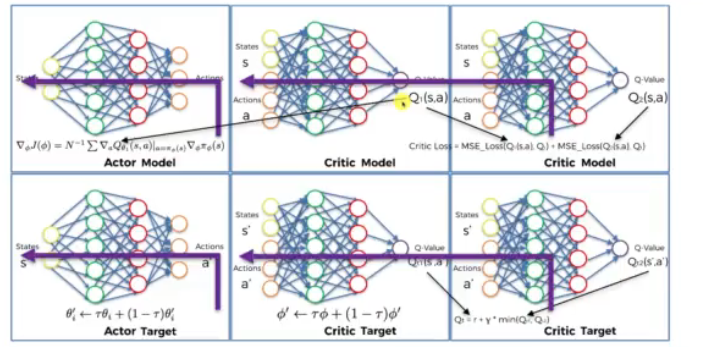

## Installing the packages

In [ ]:
!pip install pybullet

## Importing the libraries

In [ ]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pybullet_envs
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
# from gym import wrappers # old
from gym.wrappers import RecordVideo # new
from torch.autograd import Variable
from collections import deque

# Step 1: Initialize the Experience Replay memory

In [ ]:
class ReplayBuffer(object):
  """
    The experience replay memory
    ----------------------------
    This object will store the experience of learning in a list.
    - `[(s,a,s',r), (s,a,s',r), ... , (s,a,s',r)]`

    Parameters
    ----------
    - `max_size`: the maximum experiences to store (default `1e6` elements.).

    Attributes
    ----------
    - `storage`: the list for store the memories of experience.
    - `max_size`: the maximum size of `storage`
    - `ptr`: "pointer". index for a given cell in the memory. represent the transition memory.
  """
  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    """
    Add trandision to the `storage` (experience memory).

    Parameters
    ----------
    - `transition`: (s,a,s',r)
    """

    if len(self.storage) == self.max_size:      # if the length of storage = max size
      self.storage[int(self.ptr)] = transition  # we set the transition in the lest cell
      self.ptr = (self.ptr + 1) % self.max_size # than we reset the index back 1.
    else:
      # we just append the transition in the memory.
      self.storage.append(transition)

  def sample(self, batch_size):
    """
    Samples random transitions from the memoey and put them into 4 bathes:
    - `batch_states`: batch that hold the states.
    - `batch_next_states`: batch that hold the next states.
    - `batch_actions`: batch that hold the actions.
    - `batch_rewards`: batch that hold the rewards.
    - `batch_dones`: batch that represent if the game is done. (e.g: `[False,False,False,...,True]`)

    Parameters
    ----------
    - `batch_size`: the size of the batches.

    """
    # 1. select random `batch_size` index from the range of 0 to len(storage)
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    # 2. initialize the different batches
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    # 3. loop over the  `batch_size` random indexes
    for i in ind:
      # 4. extract the random transition from the memory
      state, next_state, action, reward, done = self.storage[i]
      # 5. append the different batches
      # each part from the transition as array of [single element].
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))

      # return all the different batches in a numpy array.
      # reshape to 1D array the `batch_rewards` and `batch_dones`,
      # The reshaping is necessary because the `rewards` and `done` flags are collected as
      # single elements for each transition, but they need to be arranged in batches.
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

# Step 2: Build one neural network for the Actor model and one neural network for the Actor target

In [ ]:
class Actor(nn.Module):
  """
  Create the Actor model and Actor target ANNs.
  hinherit from the `nn.module` from PyTorch.

 Parameters
  -----------
  - `state_dim`: the input shape (take the states dimenstions as the input of the NN.)
  - `action_dim`: the output shape (output as the number of actions.)
  - `max_action`: used to scale the output of the neural network, specifically in the
                  last layer of the Actor class. This scaling is applied to ensure that
                  the output values fall within a specific range,
                  which is often important in reinforcement learning contexts,
                  especially when dealing with continuous action spaces.
  """
  def __init__(self, state_dim, action_dim, max_action):
    """
    Initialize the layers (build the model architecture).
    """
    super(Actor, self).__init__() # activate the inheritance
    self.layer_1 = nn.Linear(state_dim, 400)  # layer 1 | input (state_dim), output(400)
    self.layer_2 = nn.Linear(400, 300)        # layer 2
    self.layer_3 = nn.Linear(300, action_dim) # layer 3 | output (action_dim)
    self.max_action = max_action              # set the max action

  def forward(self, x):
    """
    forward propagation the model

    Parameters
    ---------
    - `x`: the input state
    """
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))

    # scale the output & return
    # tahn: applies the hyperbolic tangent activation function to squash the
    #       raw output values to the range [-1, 1]. This is a common
    #       activation function for the output layer when dealing with
    #       continuous action spaces.
    x = self.max_action * torch.tanh(self.layer_3(x))
    return x

# Step 3: Build two neural networks for the __two Critic models__ and two neural networks for the __two Critic targets__

In [ ]:
class Critic(nn.Module):
  """
  Create a model for Tritic model and Critic action
  """
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()

    ## Defining the first Critic neural network

    # Input: both the state and actions.
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    # Output: 1 - Q(s,a), (the Q-value)
    self.layer_3 = nn.Linear(300, 1)

    ## Defining the second Critic neural network

    # input: both the state and actions.
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    # Output: 1 - Q(s,a), (the Q-value)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    """
    Forward propegations both the states and actions

    Parameters:
    ----------
    - `x`: input 1: the state
    - `u`: input 2: the actions
    """
    # xu => forward propagating the concatenation of both the state and the action
    #       1: concatinate the state and action in axis-1 (verticaly).
    xu = torch.cat([x, u], 1)

    ## Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    ## Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2 # return Q-value1,Q-value2

  def Q1(self, x, u):
    """
    Return the Q-value of the first Critic model.
    - will only use for that step of gradient descent updating the
      weights of our actor model.
    - its based in the TD3 architecture (see the image at the start of this notebook)
    """
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

# Steps 4 to 15: Training Process

In [ ]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  """
  The Twin Delay DDPG (reinforcement learning)

  Parameters:
  ---------
  - `state_dim`: states dimenstions (shape)
  - `state_dim`: action dimenstions (shape)
  - `max_action`: scaling parameter (maximum value of the action that supports the env)
  """

  def __init__(self, state_dim, action_dim, max_action):
    """
    Initialize the Actor model & Actor target and Critic model & Critic target.

    By the TD3, for create stability, the Actor/Critic target gets the weights of the
    Actor/Critic model.
    """
    # Actor model & Actor target
    self.actor = Actor(state_dim, action_dim, max_action).to(device) # Create actor model
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device) # Create actor target
    self.actor_target.load_state_dict(self.actor.state_dict()) # Load the actor target with the weights of the actor model. (as step of TD3 for reach more stability)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters()) # add optimizer to the actor model

    # Critic model & Critic target
    self.critic = Critic(state_dim, action_dim).to(device) # Create the Critic model
    self.critic_target = Critic(state_dim, action_dim).to(device) # Create the Critic target
    self.critic_target.load_state_dict(self.critic.state_dict()) # Load the Critic weigths with the weiths of the Critic model.  (as step of TD3 for reach more stability)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters()) # define optimizer to the Critic model

    self.max_action = max_action # set the max action.

  def select_action(self, state):
    """
    Function for select action from the actor.

    Parameters:
    -----------
    - `state`: the state that we'll pass to the actor for getting the action back.
    """
    # format (to 1D) the state into tensor, and push to the device (cpu/gpu)
    state = torch.Tensor(state.reshape(1, -1)).to(device)

    # call the Actor model, send the input `state`,
    # and get the action as output of the model.
    # (forward propigate the state into the Actor model ANN.)
    # the reason why we convert it back into a numpy array is because
    # that at some point we:
    # - clip the action with numpy.
    # - adding some noise to the action with numpy.
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    """
    Train the TD3 model.

    Parameters:
    -----------
    - `replay_buffer`: the memory of the agent
    - `iterations`: number of iterations for sampling batch from the memory
    - `batch_size`: batch size.
    - `discount`: the discount factor of updating.
    - `tau`: for update the parameters of both Actor target and the two critic targets.
    - `policy_noise`: for make exploration. the standard deviation in the Gaussian distribution that we'll use to sample the noise to add to our actions.
    - `noise_clip`: when we sample a noise for add to an action, we actually clip that noise and we clip it with some value
    - `policy_freq`: the frequency of the delay, default=2, (we update the Actor/Critic target with the wegiths of the Actor/Critic model each 2 iterations.)
    """
    for it in range(iterations):


      """
      Step 4: Sample from Replay Buffer
      =================================

      Sample a batch of transitions (s, s’, a, r) from the memory

      Remind that the TD3 model is an off policy model, its mean that
      Its Critic twins will learn the values from past data (past transitions),
      and that's why we made this memory to learn from the past.

      So we sampling some past transitions from the memory,
      from which our model will learn the Q-values.

      By sampling randomly from this buffer, the agent can learn from a diverse
      set of experiences, reducing the risk of overfitting to recent experiences.
      """
      # call the sample() method -> extract the transitions batch
      # we turn the batches into tensor (beacuse thay are'll go to ANN)
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device) # state batch [s]
      next_state = torch.Tensor(batch_next_states).to(device) # next state batch [s']
      action = torch.Tensor(batch_actions).to(device) # next action batch [a]
      reward = torch.Tensor(batch_rewards).to(device) # reward batch [124]
      done = torch.Tensor(batch_dones).to(device) # donr batch [False]

      """
      Step 5: Target Actor Prediction
      ===============================
      From the next state (s’), the Actor target plays the next action (a’)
      """
      # send the state the the actor target -> get the next action.
      next_action = self.actor_target(next_state)

      """
      Step 6: Adding Exploration Noise
      ==================================
      Add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment.
      - create an Gaussian noise distribution.
      - clamp the Gaussian noise into range.
      - add the noise to the action, then clamp then toghther into range.

      To encourage exploration, noise is added to the next action.
      This noise is drawn from a normal distribution and is clipped to a certain range.
      This is a form of exploration strategy,
      preventing the agent from being overly deterministic and
      potentially discovering better policies.
      """
      # `torch.Tensor(batch_actions)` -> get the batch action as a tensor
      # `data.normal_(0, policy_noise)` -> add Gaussian normal of mean 0 and std `policy_noise` to the batch action
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      # clamp that noise into range of [noise_clip,-noise_clip]
      noise = noise.clamp(-noise_clip, noise_clip)
      # clamp the (action + noise) into range of [max_action, -max_action], as the
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)

      """
      Step 7: Target Q-Values Prediction
      ===================================
      The two Critic targets take each the couple (s’, a’) as input,
      and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      """
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)

      """
      Step 8: Minimum Target Q-Value
      ===============================
      We keep the minimum of these two Q-values: min(Qt1, Qt2)

      This is a conservative approach that helps in reducing the
      overestimation bias. By taking the minimum,
      the algorithm is less sensitive to errors in the Q-value estimation.
      """
      target_Q = torch.min(target_Q1, target_Q2)

      """
      Step 9: Update Target Q-Value
      ========
      We get the final target of the two Critic models,
      which is: Qt = r + γ * min(Qt1, Qt2),
      where γ is the discount factor.

      The target Q-value is updated by adding the current reward and the
      discounted future Q-value. If the episode is done (done is 1),
      the future Q-value is not considered since there are no more future rewards.
      """
      target_Q = reward + ((1 - done) * discount * target_Q).detach()

      """
      Step 10: Current Q-Values Prediction
      ====================================
      The two Critic models take each the couple (s, a) as input,
      and return two Q-values Q1(s,a) and Q2(s,a) as outputs

      The current Q-values for the state and action are predicted using the critic network.
      This is the critic's estimate of the current state-action value.
      """
      current_Q1, current_Q2 = self.critic(state, action)

      """
      Step 11: Critic Loss Calculation
      =================================
      We compute the loss coming from the two Critic models:
      The critic loss is calculated as the mean squared error between the
      current Q-values and the updated target Q-value.
      This loss represents how well the critic is approximating the true Q-values.
      """
      # Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      # Critic loss is the error between the Q of Critic models to the Q of the Critic target.
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

      """
      Step 12: Critic Network Update
      ================================
      We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      """
      self.critic_optimizer.zero_grad() # initialize the gradient (reset the gradient back to 0)
      critic_loss.backward() # backward propegation the Critic loss (to the Critic models). calculates the gradients of the loss
      self.critic_optimizer.step() # updates the parameters of the critic neural network

      """
      Step 13: Actor Network Update (Every policy_freq Iterations)
      ===============================================================
      Once every `policy_freq` iterations, we update our Actor model by performing
      gradient ascent (not decent!) on the output of the first Critic model,
      for maximize the Q values of the state action pairs.
      why we do that? where the Actor'll return action that yield higehr Q-values,
      we'll also get higer expected return.

      The actor is updated to maximize the expected return,
      as estimated by the critic. The negative mean Q-value is used as the
      actor loss. This encourages the actor to take
      actions that lead to higher Q-values.
      """
      if it % policy_freq == 0:
        # Send to the forst Critic model (state,action (apply the chain rule)), and
        # take the get back (-)Q1 value.
        # then we take the mean (mean of Q-values from a batch).
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad() # initial the gradient
        actor_loss.backward() # backward propagate
        self.actor_optimizer.step() # update the model parameters.

        """
        Steps 14 & 15: Target Network Updates
        ======================================
        Still once every two iterations, we update the weights of the Actor target by polyak averaging

        The target networks (both actor and critic) are updated using a soft update
        strategy. This involves a weighted combination of the current
        network parameters and the target network parameters.
        This helps stabilize the training process and avoid
        sudden changes in the target networks.
        """
        # loop over the weights of the Actor target (the once we want to update),
        # and over the weights of the Actor model (for use them to update the  Actor target weights)
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          # fine-tune the weigths of the Actor target (`target_param`) according to the
          # weigths of the Actor model (`param`).
          # tau: updating discount (e.g: take 0.2 from Actor model and 0.8 from target model)
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        """
        Step 15:
        =========
        Still once every two iterations, we update the weights of the Critic target by polyak averaging
        (its the same as we did in step)
        """
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Function that __evaluates the policy__ by calculating its average reward over 10 episodes

In [ ]:
def evaluate_policy(policy, eval_episodes=10):
  """
  Function that evaluates the policy by
  calculating its average reward over 10 episodes.
  """
  avg_reward = 0. # initial avarage reward
  for _ in range(eval_episodes): # loop over the episodes
    obs = env.reset() # rest env, get the initial state
    done = False # end condition
    while not done:
      action = policy.select_action(np.array(obs)) # given a state get back an action
      obs, reward, done, _ = env.step(action) # perform the action
      avg_reward += reward # updating the reward.

  # take the avarage reward over the epicodes
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

## We set the parameters

In [ ]:
env_name = "AntBulletEnv-v0" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network (explorations)
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate (the weigths of Target according the Model  )
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [ ]:
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: TD3_AntBulletEnv-v0_0
---------------------------------------


## We create a folder inside which will be saved the trained models

In [ ]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

## We create the PyBullet environment

In [ ]:
env = gym.make(env_name)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<AntBulletEnv<AntBulletEnv-v0>>>>>>

## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [ ]:
# set seed
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# get the states & actions shapes and the max_action
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [ ]:
state_dim, action_dim, max_action

(28, 8, 1.0)

## We create the policy network (the Actor model)

In [ ]:
# the TD3 reinforcement learning algorithem
policy = TD3(state_dim, action_dim, max_action)

## We create the Experience Replay memory

In [ ]:
replay_buffer = ReplayBuffer()

## We define a list where all the evaluation results over 10 episodes are stored

In [ ]:
evaluations = [evaluate_policy(policy)]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

---------------------------------------
Average Reward over the Evaluation Step: 9.807990
---------------------------------------


## We create a new folder directory in which the final results (videos of the agent) will be populated

In [ ]:
# ------------------ old ------------------
# def mkdir(base, name):
#     path = os.path.join(base, name)
#     if not os.path.exists(path):
#         os.makedirs(path)
#     return path


# work_dir = mkdir('exp', 'brs')
# monitor_dir = mkdir(work_dir, 'monitor')
# max_episode_steps = env._max_episode_steps
# save_env_vid = False
# if save_env_vid:
#   env = wrappers.Monitor(env, monitor_dir, force = True)
#   env.reset()

In [ ]:
# ------------------ new -----------------------
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path


work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
max_episode_steps = env.spec.max_episode_steps
save_env_vid = False
if save_env_vid:
  env = RecordVideo(env, monitor_dir, video_callable=lambda episode_id: True)
  env.reset()


## We initialize the variables

In [ ]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training

In [ ]:
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:

  # If the episode is done
  if done:

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      # train the DDPG
      policy.train(replay_buffer,     # the memory
                   episode_timesteps, # number of epicodes
                   batch_size, # batch size
                   discount,   # discount factor (0 to 1)
                   tau,        # weigths updating factor (0 to 1)
                   policy_noise, # policy noise
                   noise_clip,   # clip noise
                   policy_freq)  # policy frequency

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)

    # When the training step is done, we reset the state of the environment
    obs = env.reset()

    # Set the Done to False
    done = False

    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1 # update the number of epicodes

  # Before 10000 timesteps, we play random actions (exploration)
  if total_timesteps < start_timesteps:
    action = env.action_space.sample() # take random action
  # After 10000 timesteps, we switch to the model
  else:
    action = policy.select_action(np.array(obs))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      # add noise to the action
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)


  # The agent performs the action in the environment,
  # then reaches the next state and receives the reward
  new_obs, reward, done, _ = env.step(action)

  # We check if the episode is done
  done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)

  # We increase the total reward
  episode_reward += reward

  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  # (s,s',a,r)
  replay_buffer.add((obs, new_obs, action, reward, done_bool))

  # Updating
  obs = new_obs # update the state,
  episode_timesteps += 1 # update the episode timestep
  total_timesteps += 1 # update the total timesteps
  timesteps_since_eval += 1 # update the timesteps since the evaluation of the policy


# ----------

# We add the last policy evaluation to our list of evaluations
evaluations.append(evaluate_policy(policy))

# save our model
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Total Timesteps: 1000 Episode Num: 1 Reward: 490.58764666670305
Total Timesteps: 2000 Episode Num: 2 Reward: 499.93074957532986
Total Timesteps: 3000 Episode Num: 3 Reward: 529.4625726377966
Total Timesteps: 3228 Episode Num: 4 Reward: 106.23994208124495
Total Timesteps: 3954 Episode Num: 5 Reward: 386.23374223512144
Total Timesteps: 4954 Episode Num: 6 Reward: 502.7878321484676
Total Timesteps: 5954 Episode Num: 7 Reward: 492.1929185471494
---------------------------------------
Average Reward over the Evaluation Step: 158.422747
---------------------------------------
Total Timesteps: 5974 Episode Num: 8 Reward: 3.123111824925582
Total Timesteps: 6974 Episode Num: 9 Reward: 503.15135502703635
Total Timesteps: 7160 Episode Num: 10 Reward: 84.86207183363445
Total Timesteps: 8160 Episode Num: 11 Reward: 498.49756880412224
Total Timesteps: 9160 Episode Num: 12 Reward: 475.4593332175685
Total Timesteps: 9332 Episode Num: 13 Reward: 74.23097226746324
Total Timesteps: 10332 Episode Num: 14 

# Inference
> After the AI trained, he's no longer train and update its weigths. its a test mood!

In [ ]:
# Its all the code, expect the training process.
class Actor(nn.Module):

  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = max_action

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = self.max_action * torch.tanh(self.layer_3(x))
    return x

class Critic(nn.Module):

  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2

  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):

  def __init__(self, state_dim, action_dim, max_action):
    self.actor = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

    for it in range(iterations):

      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)

      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)

      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)

      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)

      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)

      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()

      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)

      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(np.array(obs))
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward



env_name = "AntBulletEnv-v0"
seed = 0

file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

# -----------old-------------
# eval_episodes = 10
# save_env_vid = True
# env = gym.make(env_name)
# max_episode_steps = env._max_episode_steps
# if save_env_vid:
#   env = wrappers.Monitor(env, monitor_dir, force = True)
#   env.reset()
# -----------old-------------

# ----------- new -----------
eval_episodes = 10
env = gym.make(env_name)
max_episode_steps = env.spec.max_episode_steps
save_env_vid = True
if save_env_vid:
  env = RecordVideo(env, monitor_dir, episode_trigger=lambda episode_id: True)
  env.reset()
# ----------------------

env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
policy = TD3(state_dim, action_dim, max_action)
path = "/content/pytorch_models"
policy.load(file_name, path)
_ = evaluate_policy(policy, eval_episodes=eval_episodes)